<a href="https://colab.research.google.com/github/vbwanere/SEDS_in_jax/blob/main/gmr_lib/GMR_from_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **GMR from scratch**

Python jax implementation of Gaussian Mixture Regression Model

# 1\. Introduction:

We estimate a joint density of the inputs $x\  \epsilon \ \mathbb R^N$ and outputs $\dot x \ \epsilon \ \mathbb R^P$ through a K-component Gaussian mixture model as follows:

\begin{equation}
\tag{1}
p(x, \dot x|\Theta) = \sum_{k=1}^{K} \pi_k p(x, \dot x|\mu^k \Sigma^k)
\end{equation}

where,\
$\sum_{k=1}^{K} \pi_k = 1$ and $\mu^k = \begin{bmatrix}
\mu_{x}^{k}\\
\mu_{\dot x}^{k}
\end{bmatrix}$,
and $\ \Sigma^k =
\begin{bmatrix}
\Sigma_{xx}^{k} & \Sigma_{x\dot x}^{k} \\
\Sigma_{\dot xx}^{k} & \Sigma_{\dot x \dot x}^{k}
\end{bmatrix}$.

The conditional density is given by:
\begin{equation}
\tag{2}
p(\dot x|x) = \sum_{k=1}^{K} \gamma_k p(y|x;\mu^k \Sigma^k)
\end{equation}

where,
\begin{equation}
\tag{3}
\gamma_k = \frac{\pi_k p(x|\mu_x^k, \Sigma_{xx}^k)}{\sum_{k=1}^{K} \pi_k p(x|\mu_x^k, \Sigma_{xx}^k)}
\end{equation}

The regressive function $\dot x = f(x)$ is given by the expectation over this conditional density:
\begin{equation}
\tag{4}
\dot x = f(x) = \mathbf E[p(\dot x|x)] = \sum_{k=1}^{K} \gamma_k(x)\tilde \mu^k(x)
\end{equation}

where,
\begin{equation}
\tag{4}
\tilde \mu = \mu_{\dot x}^k + \Sigma_{\dot x x}^k(\Sigma_{x x}^k)^{-1}(x - \mu_x^k)
\end{equation}


## 1.1 Undestanding the dataset:

1. Inputs $x \ \epsilon \ \mathbb R^N$, for $M$ number of trajectories with each of length $T_m$ we have for $m^{th}$ trajectory:
\begin{equation}
X_m =
\begin{bmatrix}
x_1^1 & x_1^2 & ....... & x_1^{T_m}\\
& & &\\
x_N^1 & x_N^2 & ....... & x_N^{T_m}\\
\end{bmatrix}
\end{equation}

where, $m \ \epsilon \  \{1,....,M\}$, and $\{\mathbf X, \dot{\mathbf X}\} = \{X^m, \dot X^m\}_{m=1}^{M} = \{\{{x^{t,m}, {\dot x^{t,m}}\}_{t=1}^{T_m}}\}_{m=1}^{M}$.

# 2\. `GMR` class:

In [4]:
import numpy as np
import jax.numpy as jnp
from jax import grad, jacfwd, jit, random, vmap
from jax.scipy.stats import multivariate_normal
from sklearn import mixture
import scipy
import scipy.io
import pprint as pp
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import itertools

Importing LASA Handwritten Dataset:\
Please refer to [this python library](https://github.com/justagist/pyLasaDataset) for the [Handwritten Human Motion LASA Datset](https://www.epfl.ch/labs/lasa/datasets/).\
Please understand the dataset [here](https://bitbucket.org/khansari/lasahandwritingdataset/src/master/Readme.txt).

In [5]:
from pyLasaDataset import DataSet as lasa
from pyLasaDataset import utilities
plot_lasa = utilities.plot_model

Using LASA DataSet from /home/vbwanere/.local/lib/python3.10/site-packages/pyLasaDataset/resources/LASAHandwritingDataset/DataSet


Import the `GaussianMixture` class from **gaussian_mixture** file:

In [6]:
import sys
sys.path.append('/home/vbwanere/OneDrive/GitHub_repos/GitHub_repos_python/seds_in_jax/gmm_lib')
from gaussian_mixture import GaussianMixture

Visualizing Trajectories:

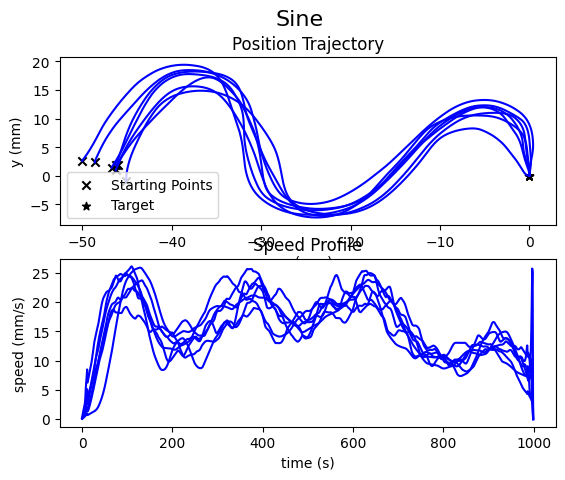

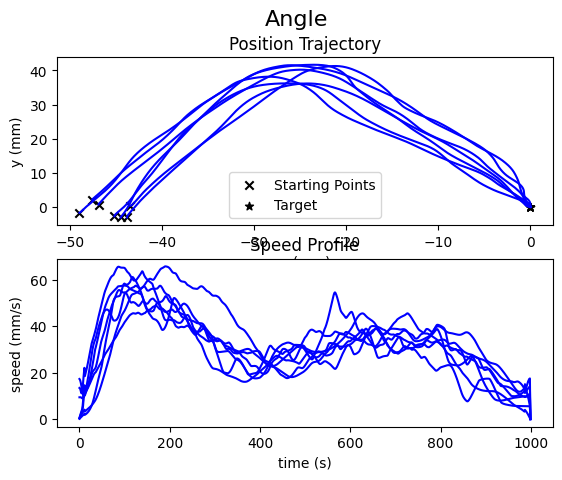

In [7]:
sine = lasa.Sine
angle = lasa.Angle
plot_lasa(sine)
plot_lasa(angle)

Using GMR for position dataset:

In [8]:
angle_demos = angle.demos
angle_1 = angle_demos[0]

# angle position
angle_pos = angle_1.pos.T # shape (1000, 2)

# angle velocity
angle_vel = angle_1.vel.T # shape (1000, 2)

for i in range(len(angle_demos)-1):
    concat_angle_pos = np.concatenate((angle_pos, (angle_demos[i+1].pos.T)), axis= 0 )
    angle_pos = concat_angle_pos
    
for i in range(len(angle_demos)-1):
    concat_angle_vel = np.concatenate((angle_vel, (angle_demos[i+1].vel.T)), axis= 0 )
    angle_vel = concat_angle_vel
    
# angle position and velocity: angle_dynamics:
angle_dynamics = np.concatenate((angle_pos, angle_vel), axis=1)

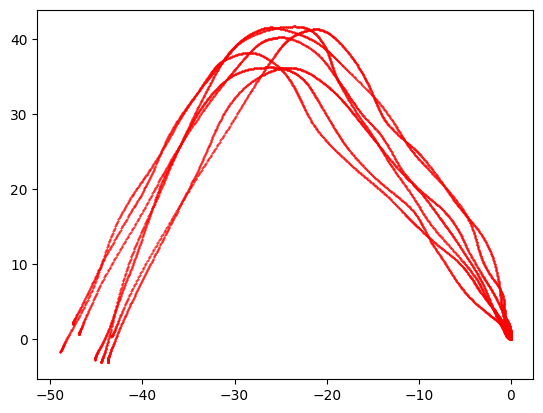

In [9]:
plt.scatter(angle_dynamics[:, 0], angle_dynamics[:, 1], c='r', marker = '.', s=0.8)

In [10]:
gmm_angle =  GaussianMixture(k=2, max_iter=60)
gmm_angle.fit(angle_dynamics[:, :2])
pred_angle_pos = gmm_angle.predict(angle_dynamics[:, :2])

In [11]:
def plot_gmm(mean, cov, color='k'):
    """Plot a single gaussian component"""
    # Get the eigenvalues and eigenvectors
    eigen_vals, eigen_vecs = np.linalg.eig(cov)

    # Get the index of the largest eigenvalue 
    idx = eigen_vals.argsort()[::-1] 
    eigen_vals, eigen_vecs = eigen_vals[idx], eigen_vecs[:,idx]

    theta = np.degrees(np.arctan2(*eigen_vecs[:,0][::-1]))

    # Ellipse properties 
    width, height = 2 * np.sqrt(eigen_vals)
    ellipse = patches.Ellipse(mean, width, height, angle=theta, facecolor='none', edgecolor=color)
    # ellipse.set_linestyle('--')
    ellipse.set_linewidth(4)
    return ellipse

In [12]:
angle_pos[pred_angle_pos == 0, 0].shape[0]

4186

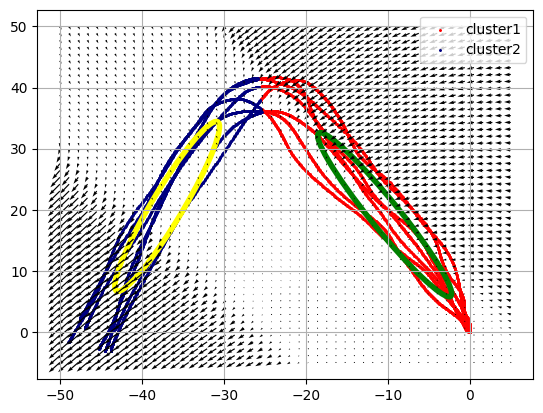

In [53]:
color_iter_data = itertools.cycle(["red", "navy", "c", "cornflowerblue", "gold",\
    "darkorange", "green", "blue", "purple", "pink"])
color_iter_gmm = itertools.cycle(["green", "yellow", "black", "cornflowerblue", "gold"])

# plt.figure(figsize=(10, 10))
fig, ax = plt.subplots()
for i in range(gmm_angle.k):
    ax.scatter(angle_dynamics[:, :2][pred_angle_pos == i, 0],\
        angle_dynamics[:, :2][pred_angle_pos == i, 1], s=5,\
        c=next(color_iter_data), marker='.', label='cluster' + str(i + 1))
    # ax.quiver(angle_dynamics[:, :2][pred_angle_pos == i, 0],\
        # angle_dynamics[:, :2][pred_angle_pos == i, 1],\
        # angle_dynamics[:, 2:][pred_angle_pos == i, 0],\
        # angle_dynamics[:, 2:][pred_angle_pos == i, 1])

for i in range(gmm_angle.k):
    ellipse = plot_gmm(gmm_angle.means[i], gmm_angle.covariances[i], color=next(color_iter_gmm))
    ax.add_patch(ellipse)

ax.quiver(test_pos[:, 0],\
        test_pos[:, 1],\
        pred_vel[:, 0],\
        pred_vel[:, 1])  
# ax.set_xlim(-55, 5)
# ax.set_ylim(-10, 45)
# plt.title('Clustered Data Using GMM')
plt.legend(scatterpoints=1)
plt.grid()
plt.show()

Fitting GMM on the `angle_dynamics` data:

In [14]:
from gmr.utils import check_random_state
from gmr import MVN, GMM, plot_error_ellipses

In [23]:
gmm = GMM(n_components=3, random_state=0)
gmm.from_samples(angle_dynamics)

In [50]:
import numpy as np

# Define the range and number of points for x and y
x_start, x_end = -50, 5
y_start, y_end = -5, 50
num_points = 50  # Number of points in each dimension

# Generate the grid dataset using np.linspace
x_values = np.linspace(x_start, x_end, num_points)
y_values = np.linspace(y_start, y_end, num_points)

# Create a meshgrid from the x and y values
x_grid, y_grid = np.meshgrid(x_values, y_values)

# Flatten the grids to create the dataset
x_dataset = x_grid.flatten()
y_dataset = y_grid.flatten()

# Combine x and y values to create the final 2D dataset
test_pos = np.column_stack((x_dataset, y_dataset))


In [51]:
pred_vel = gmm.predict(np.array([2, 3]), test_pos)

In [44]:
pred_vel.shape

(2500, 2)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


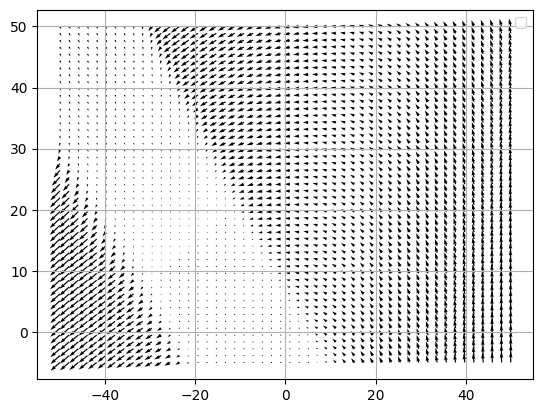

In [47]:
fig, ax = plt.subplots()
ax.quiver(test_pos[:, 0],\
        test_pos[:, 1],\
        pred_vel[:, 0],\
        pred_vel[:, 1])    
# ax.set_xlim(-55, 5)
# ax.set_ylim(-10, 45)
# plt.title('Clustered Data Using GMM')
plt.legend(scatterpoints=1)
plt.grid()
plt.show()

## 1.2 Subsection 2:

In [ ]:
"""
sample code here
"""

### 1.2.1 item 1:

In [ ]:
"""
sample code here
"""

### 1.2.2 item 2:

In [ ]:
"""
sample code here
"""

# 2\. Section 2:

## 2.1\. Subsection 1:
### Subsection description in one line:

In [4]:
from pprint import pprint as print

In [5]:
print("The function predicts the class labels for a given set of input data.\
      :param X: The parameter X represents the input data for which you want to make predictions.\
      It is a matrix or array-like object with shape (n_samples, n_features),\
      where n_samples is the number of samples or instances in the dataset, and n_features is the number of features or\
      attributes for each sample:return: the index of the maximum probability value in the responsibility_k matrix for each data point.")

('The function predicts the class labels for a given set of input data.      '
 ':param X: The parameter X represents the input data for which you want to '
 'make predictions.      It is a matrix or array-like object with shape '
 '(n_samples, n_features),      where n_samples is the number of samples or '
 'instances in the dataset, and n_features is the number of features or      '
 'attributes for each sample:return: the index of the maximum probability '
 'value in the responsibility_k matrix for each data point.')
